In [1]:
from core.networks.SRGAN import Generator, Discriminator

import torch
import torch.nn as nn
import torch.optim as optim
import ignite.metrics as metrics
from torchvision import transforms
from torchvision.transforms import functional as TF
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_model, save_model
from PIL import Image

from data.get_data import get_bsds300, get_bsd100
import core.utils as U
from core.device import get_device
from core.loss import GeneratorLoss

In [2]:
model_path = "./models"
result_path = "./results"

batch_size = 20
epochs = 200
optimizer = "SGD_LRD"
generator_lr = 1e-4
discriminator_lr = 1e-4
upscale_factor = 4

generator_name = "SRGAN_generator"
discriminator_name = "SRGAN_discriminator"
device = get_device()

In [3]:
train_loader, val_loader = get_bsds300(upscale_factor=4, batch_size=batch_size)
test_loader = get_bsd100(4, batch_size)

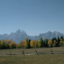

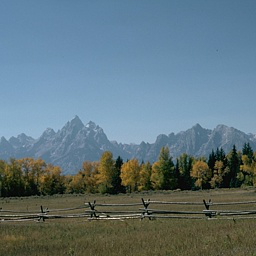

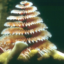

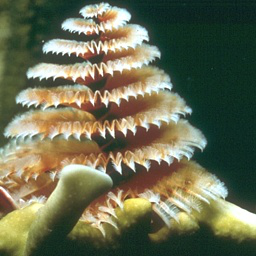

In [4]:
dateiter = iter(train_loader)
inputs, targets = next(dateiter)

for i in range(min(2, len(inputs))):
    image = TF.to_pil_image(inputs[i])
    target = TF.to_pil_image(targets[i])
    display(image)
    display(target)
    

In [5]:
generator = Generator(5)
discriminator = Discriminator()

use_pretrained_model = False

try:
    load_model(generator, f"{model_path}/{generator_name}.safetensors")
    load_model(discriminator, f"{model_path}/{discriminator_name}.safetensors")
    use_pretrained_model = True
    print("Loaded pretrained model")
except:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)
    print("No pretrained model found")

generator.to(device)
discriminator.to(device)

print("Model loaded")

No pretrained model found
Model loaded


In [7]:
generator_optimizer = optim.Adam(generator.parameters(), lr=generator_lr, betas=(0.9, 0.999))
generator_scheduler = optim.lr_scheduler.StepLR(generator_optimizer, step_size=int(epochs/2), gamma=0.1)

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
discriminator_scheduler = optim.lr_scheduler.StepLR(discriminator_optimizer, step_size=int(epochs/2), gamma=0.1)

generator_criterion = GeneratorLoss().to(device)

In [7]:
from math import log10
loss_history = {
    "g_loss": [],
    "d_loss": [],
    "g_score": [],
    "d_score": [],
    "psnr": [],
    "ssim": []
}

if not use_pretrained_model:
    
    for epoch in range(1, epochs + 1):
        generator.train()
        discriminator.train()
        
        running_loss = {"g_loss": 0, "d_loss": 0, "g_score": 0, "d_score": 0}

        for i, data in enumerate(train_loader):
            inputs, targets = data[0].to(device), data[1].to(device)
            
            generator_optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            
            outputs = generator(inputs)
            
            # 1. update discriminator
            d_real = discriminator(targets).mean()
            d_fake = discriminator(outputs).mean()
            
            d_loss = 1 - d_real + d_fake
            d_loss.backward()
            discriminator_optimizer.step()

            # 2. update generator
            d_fake = discriminator(outputs)
            g_loss = generator_criterion(d_fake, outputs, targets)
            g_loss.backward()
            
            outputs = generator(inputs)
            d_fake = discriminator(outputs).mean()
            

            generator_optimizer.step()
            
            running_loss["g_loss"] += g_loss.cpu().item() * batch_size
            running_loss["d_loss"] += d_loss.cpu().item() * batch_size
            running_loss["g_score"] += d_real.cpu().item() * batch_size
            running_loss["d_score"] += d_fake.cpu().item() * batch_size
        
        generator_scheduler.step()
        discriminator_scheduler.step()
        
        generator.eval()

        with torch.no_grad():
            valing_results = {"mse": 0, "ssims": 0, "psnr": 0, "ssim": 0}
            
            for i, data in enumerate(val_loader):
                inputs, targets = data[0].to(device), data[1].to(device)
                outputs = generator(inputs)
                
                mse = torch.mean((outputs - targets) ** 2)
                valing_results["mse"] += mse.cpu().item() * batch_size
                valing_results["psnr"] += 10 * log10(1 / (mse.item() + 1e-8))
                
                valing_results["ssims"] += pytorch_ssim.ssim(outputs, targets).item() * batch_size
                valing_results["ssim"] += pytorch_ssim.ssim(outputs, targets).item()
            
            
        
        loss_history['d_loss'].append(running_loss['d_loss'] / running_loss['batch_sizes'])
        loss_history['g_loss'].append(running_loss['g_loss'] / running_loss['batch_sizes'])
        loss_history['d_score'].append(running_loss['d_score'] / running_loss['batch_sizes'])
        loss_history['g_score'].append(running_loss['g_score'] / running_loss['batch_sizes'])
        loss_history['psnr'].append(valing_results['psnr'])
        loss_history['ssim'].append(valing_results['ssim'])

    save_model(generator, f"{model_path}/{generator_name}.safetensors")
    save_model(discriminator, f"{model_path}/{discriminator_name}.safetensors")

torch.Size([20, 3, 64, 64])


TypeError: GeneratorLoss.forward() missing 1 required positional argument: 'target_images'